
# Sepsis 2019 — Predicción a 6 horas con ML clásico (LogReg vs HGB)

Notebook para entrenar **Logistic Regression** y **HistGradientBoosting** anticipando sepsis a **6 horas** con `SepsisLabel_h6`.
Incluye *feature engineering* temporal (ventana 6h, deltas, time-since, flags de medición) y evaluación con **AUROC/AUPRC**.

**Columnas permitidas**:  
`['patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'subHR', 'Alkalinephos', 'BaseExcess', 'Bilirubin_direct', 'Bilirubin_total', 'DBP',  'FiO2',  'Gender', 'HCO3', 'HR',  'HospAdmTime', 'Lactate', 'Magnesium', 'O2Sat', 'Resp', 'SaO2', 'TroponinI', 'Unit2']`



## Requisitos
```bash
pip install pandas pyarrow numpy scikit-learn matplotlib seaborn joblib
```


In [10]:

import numpy as np
import pandas as pd
from pathlib import Path
import os

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc, classification_report
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump

pd.options.display.max_columns = 200


In [2]:
MLFLOW_TRACKING_URI = "http://107.22.141.105:8050/"
EXPERIMENT_NAME = "sepsis_challenge"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

2025/09/03 19:47:40 INFO mlflow.tracking.fluent: Experiment with name 'sepsis_challenge' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/639501076581994165', creation_time=1756946861078, experiment_id='639501076581994165', last_update_time=1756946861078, lifecycle_stage='active', name='sepsis_challenge', tags={}>

In [11]:
os.makedirs("artifacts", exist_ok=True)

def plot_and_log_curves(y_true, y_prob, run_prefix):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {run_prefix}")
    roc_path = f"artifacts/{run_prefix}_roc.png"
    plt.savefig(roc_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(roc_path)

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR – {run_prefix}")
    pr_path = f"artifacts/{run_prefix}_pr.png"
    plt.savefig(pr_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(pr_path)

    # Calibration
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives"); plt.title(f"Calibration – {run_prefix}")
    cal_path = f"artifacts/{run_prefix}_calibration.png"
    plt.savefig(cal_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(cal_path)

def log_confusion(y_true, y_prob, threshold, run_prefix):
    y_hat = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix @th={threshold:.3f} – {run_prefix}")
    cm_path = f"artifacts/{run_prefix}_cm_{threshold:.3f}.png"
    plt.savefig(cm_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(cm_path)

def best_threshold_fbeta(y_true, y_prob, beta=2.0):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)  # thr len = len(prec)-1
    best_f, best_t = 0.0, 0.5
    b2 = beta**2
    for t in thr:
        y_hat = (y_prob >= t).astype(int)
        tp = ((y_hat == 1) & (y_true == 1)).sum()
        fp = ((y_hat == 1) & (y_true == 0)).sum()
        fn = ((y_hat == 0) & (y_true == 1)).sum()
        precision = tp / max(tp + fp, 1)
        recall = tp / max(tp + fn, 1)
        fbeta = (1+b2) * precision * recall / max(b2*precision + recall, 1e-12)
        if fbeta > best_f:
            best_f, best_t = fbeta, t
    return best_f, best_t

def metrics_block(y_true, y_prob, threshold):
    """Return AUROC, AUPRC, Accuracy@th, F2@th, plus also Accuracy@0.5 and F2@0.5 (for logging)."""
    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)

    y_hat_thr = (y_prob >= threshold).astype(int)
    acc_thr = accuracy_score(y_true, y_hat_thr)

    # F2 @ threshold
    f2_thr, _ = best_threshold_fbeta(y_true, y_prob, beta=2.0)  # already computed elsewhere; safe here

    # Reference at 0.5
    y_hat_05 = (y_prob >= 0.5).astype(int)
    acc_05 = accuracy_score(y_true, y_hat_05)

    # F2 @ 0.5
    tp = ((y_hat_05 == 1) & (y_true == 1)).sum()
    fp = ((y_hat_05 == 1) & (y_true == 0)).sum()
    fn = ((y_hat_05 == 0) & (y_true == 1)).sum()
    precision_05 = tp / max(tp + fp, 1)
    recall_05 = tp / max(tp + fn, 1)
    b2 = 4.0
    f2_05 = (1+b2) * precision_05 * recall_05 / max(b2*precision_05 + recall_05, 1e-12)

    return {
        "auroc": auroc,
        "auprc": auprc,
        "acc_at_best_f2_thr": acc_thr,
        "f2_at_best_f2_thr": f2_thr,
        "acc_at_0_5": acc_05,
        "f2_at_0_5": f2_05
    }

## Configuración y carga de datos

In [3]:

DATA_DIR = Path("../data/raw")
FILE_A = DATA_DIR / "all_patients_setA.parquet"
FILE_B = DATA_DIR / "all_patients_setB.parquet"

assert FILE_A.exists(), f"No se encontró {FILE_A.resolve()}"
assert FILE_B.exists(), f"No se encontró {FILE_B.resolve()}"

allowed_cols = [
    'patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'Alkalinephos', 'BaseExcess',
    'Bilirubin_direct', 'Bilirubin_total', 'DBP',  'FiO2',  'Gender',
    'HCO3', 'HR',  'HospAdmTime', 'Lactate', 'Magnesium', 'O2Sat', 'Resp', 'SaO2', 'TroponinI', 'Unit2'
]

# Carga solo columnas disponibles en cada archivo
cols_a = [c for c in allowed_cols]
cols_b = [c for c in allowed_cols]
df_a = pd.read_parquet(FILE_A, columns=None)
df_b = pd.read_parquet(FILE_B, columns=None)
df_a = df_a[[c for c in allowed_cols if c in df_a.columns]]
df_b = df_b[[c for c in allowed_cols if c in df_b.columns]]
df = pd.concat([df_a, df_b], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (1552210, 21)


,patient_id,SepsisLabel,ICULOS,Temp,Alkalinephos,BaseExcess,Bilirubin_direct,Bilirubin_total,DBP,FiO2,Gender,HCO3,HR,HospAdmTime,Lactate,Magnesium,O2Sat,Resp,SaO2,TroponinI,Unit2
0,p000001,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p000001,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,97.0,-0.03,NaN,NaN,95.0,19.0,NaN,NaN,NaN
2,p000001,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,89.0,-0.03,NaN,NaN,99.0,22.0,NaN,NaN,NaN
3,p000001,0.0,4.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,0.0,NaN,90.0,-0.03,NaN,NaN,95.0,30.0,NaN,NaN,NaN
4,p000001,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.28,0.0,NaN,103.0,-0.03,NaN,NaN,88.5,24.5,NaN,NaN,NaN


## Construcción de `SepsisLabel_h6` (anticipación 6h)

In [4]:

id_col = "patient_id"
t_col  = "ICULOS"
y_col  = "SepsisLabel"

df = df.sort_values([id_col, t_col]).reset_index(drop=True)

# Onset por paciente
onset_df = (
    df[df[y_col] == 1]
    .groupby(id_col, as_index=False)[t_col]
    .min()
    .rename(columns={t_col: "onset_hour"})
)
df = df.merge(onset_df, on=id_col, how="left")
df["hrs_to_onset"] = df["onset_hour"] - df[t_col]

# Positivo si el onset ocurre en 1..6 horas
df["SepsisLabel_h6"] = 0
mask_on = df["onset_hour"].notna()
df.loc[mask_on & (df["hrs_to_onset"] >= 1) & (df["hrs_to_onset"] <= 6), "SepsisLabel_h6"] = 1

# Quitar filas posteriores al onset (opcional recomendado)
df = df[(df["onset_hour"].isna()) | (df[t_col] < df["onset_hour"])].copy()

df[[id_col, t_col, y_col, "SepsisLabel_h6", "onset_hour", "hrs_to_onset"]].head(10)


,patient_id,ICULOS,SepsisLabel,SepsisLabel_h6,onset_hour,hrs_to_onset
0,p000001,1.0,0.0,0,NaN,NaN
1,p000001,2.0,0.0,0,NaN,NaN
2,p000001,3.0,0.0,0,NaN,NaN
3,p000001,4.0,0.0,0,NaN,NaN
4,p000001,5.0,0.0,0,NaN,NaN
5,p000001,6.0,0.0,0,NaN,NaN
6,p000001,7.0,0.0,0,NaN,NaN
7,p000001,8.0,0.0,0,NaN,NaN
8,p000001,9.0,0.0,0,NaN,NaN
9,p000001,10.0,0.0,0,NaN,NaN


## Feature engineering temporal (6h rolling, deltas, time-since, flags)

In [5]:

base_feats = [c for c in [
    "Temp", "Alkalinephos", "BaseExcess","Bilirubin_direct","Bilirubin_total",
    "DBP","FiO2","HCO3","HR","Lactate","Magnesium","O2Sat","Resp","SaO2","TroponinI"
] if c in df.columns]

cat_feats = [c for c in ["Gender","Unit2"] if c in df.columns]
for c in cat_feats:
    df[c] = df[c].astype("category")

# Flags de medición
for c in base_feats:
    df[f"{c}_measured"] = df[c].notna().astype(int)

# Forward-fill por paciente
df[base_feats] = df.groupby(id_col, group_keys=False)[base_feats].apply(lambda g: g.ffill())

# Ventana 6h y deltas
HOURS_WINDOW = 6
for c in base_feats:
    df[f"{c}_roll{HOURS_WINDOW}"] = df.groupby(id_col)[c].transform(
        lambda s: s.rolling(window=HOURS_WINDOW, min_periods=1).mean()
    )
    df[f"{c}_delta"] = df.groupby(id_col)[c].diff()

# Time since medido
for c in base_feats:
    present = df[c].notna().astype(int)
    df[f"{c}_tsince"] = present.groupby(df[id_col]).transform(
        lambda s: s.replace(0, np.nan).groupby(s.ne(0).cumsum()).cumcount()
    )

# Ratios clínicos simples
eps = 1e-6
if {"HR","DBP"}.issubset(df.columns):
    df["shock_index"] = df["HR"] / (df["DBP"] + eps)
if {"O2Sat","FiO2"}.issubset(df.columns):
    df["s_f_ratio"] = df["O2Sat"] / (df["FiO2"] + eps)

non_feat = {id_col, t_col, "SepsisLabel", "SepsisLabel_h6", "onset_hour", "hrs_to_onset", "HospAdmTime"}
X_cols_base = base_feats + [f"{c}_measured" for c in base_feats] + \
              [f"{c}_roll{HOURS_WINDOW}" for c in base_feats] + \
              [f"{c}_delta" for c in base_feats] + \
              [f"{c}_tsince" for c in base_feats] + \
              (["shock_index"] if "shock_index" in df.columns else []) + \
              (["s_f_ratio"] if "s_f_ratio" in df.columns else [])

# One-hot para LogReg
df_cat = pd.get_dummies(df[cat_feats], drop_first=True) if cat_feats else pd.DataFrame(index=df.index)
X_df = pd.concat([df[X_cols_base], df_cat], axis=1)

y = df["SepsisLabel_h6"].astype(int).values
groups = df[id_col].values

print("Total features:", X_df.shape[1])
X_df.head()


Total features: 79


,Temp,Alkalinephos,BaseExcess,Bilirubin_direct,Bilirubin_total,DBP,FiO2,HCO3,HR,Lactate,Magnesium,O2Sat,Resp,SaO2,TroponinI,Temp_measured,Alkalinephos_measured,BaseExcess_measured,Bilirubin_direct_measured,Bilirubin_total_measured,DBP_measured,FiO2_measured,HCO3_measured,HR_measured,Lactate_measured,Magnesium_measured,O2Sat_measured,Resp_measured,SaO2_measured,TroponinI_measured,Temp_roll6,Alkalinephos_roll6,BaseExcess_roll6,Bilirubin_direct_roll6,Bilirubin_total_roll6,DBP_roll6,FiO2_roll6,HCO3_roll6,HR_roll6,Lactate_roll6,Magnesium_roll6,O2Sat_roll6,Resp_roll6,SaO2_roll6,TroponinI_roll6,Temp_delta,Alkalinephos_delta,BaseExcess_delta,Bilirubin_direct_delta,Bilirubin_total_delta,DBP_delta,FiO2_delta,HCO3_delta,HR_delta,Lactate_delta,Magnesium_delta,O2Sat_delta,Resp_delta,SaO2_delta,TroponinI_delta,Temp_tsince,Alkalinephos_tsince,BaseExcess_tsince,Bilirubin_direct_tsince,Bilirubin_total_tsince,DBP_tsince,FiO2_tsince,HCO3_tsince,HR_tsince,Lactate_tsince,Magnesium_tsince,O2Sat_tsince,Resp_tsince,SaO2_tsince,TroponinI_tsince,shock_index,s_f_ratio,Gender_1.0,Unit2_1.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN,95.0,19.0,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.00,NaN,NaN,95.000000,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,NaN,NaN,False,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,NaN,NaN,99.0,22.0,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.00,NaN,NaN,97.000000,20.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.0,NaN,NaN,4.0,3.0,NaN,NaN,2,2,2,2,2,2,2,2,0,2,2,0,0,2,2,NaN,NaN,False,False
3,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,95.0,30.0,NaN,NaN,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,92.00,NaN,NaN,96.333333,23.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-4.0,8.0,NaN,NaN,3,3,0,3,3,3,3,3,0,3,3,0,0,3,3,NaN,NaN,False,False
4,NaN,NaN,24.0,NaN,NaN,NaN,0.28,NaN,103.0,NaN,NaN,88.5,24.5,NaN,NaN,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,NaN,NaN,24.0,NaN,NaN,NaN,0.28,NaN,94.75,NaN,NaN,94.375000,23.875000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,-6.5,-5.5,NaN,NaN,4,4,0,4,4,4,0,4,0,4,4,0,0,4,4,NaN,316.0703,False,False


In [6]:
nan_summary = (
    X_df.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

# Mostrar las primeras 20 columnas con más NaN
nan_summary.head(50)

,NaN_count,NaN_percent
Bilirubin_direct_delta,1456693,95.565094
Bilirubin_direct,1454728,95.436182
Bilirubin_direct_roll6,1454728,95.436182
TroponinI_delta,1301829,85.405375
TroponinI_roll6,1294945,84.953756
TroponinI,1294945,84.953756
Lactate_delta,1089155,71.453079
Bilirubin_total_delta,1082821,71.037543
SaO2_delta,1081276,70.936184
Alkalinephos_delta,1081262,70.935266


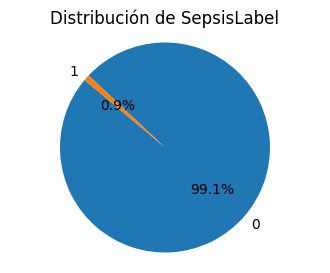

In [7]:
sepsis_counts = df['SepsisLabel_h6'].value_counts()
plt.figure(figsize=(4, 3))
plt.pie(sepsis_counts, labels=sepsis_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de SepsisLabel')
plt.axis('equal')
plt.show()

## Split por paciente (sin fuga)

In [8]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(gss.split(X_df, y, groups=groups))

X_train_df = X_df.iloc[train_idx]
y_train    = y[train_idx]
X_valid_df = X_df.iloc[valid_idx]
y_valid    = y[valid_idx]

print("Prev train:", y_train.mean(), "| Prev valid:", y_valid.mean())
X_train_df.shape, X_valid_df.shape


Prev train: 0.009165934425664617 | Prev valid: 0.009517635618940978


((1218861, 79), (305433, 79))

## Entrenamiento y evaluación

In [ ]:
# Logistic Regression
pipe_lr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced",n_jobs=-1))
])

with mlflow.start_run(run_name="LR_balanced"):
    # Tags to organize in your IA/master projector
    mlflow.set_tags({
        "project": "DesarrolloSoluciones",
        "component": "sepsis_6h",
        "model_family": "LogisticRegression",
        "dataset": "physionet2019",
        "split": "train/valid",
        "owner": "deayala"
    })
    pipe_lr.fit(X_train_df, y_train)
    p_lr = pipe_lr.predict_proba(X_valid_df)[:,1]

    # choose best threshold by F2
    f2_lr, thr_lr = best_threshold_fbeta(y_valid, p_lr, beta=2.0)

    # compute & log metrics
    block = metrics_block(y_valid, p_lr, threshold=thr_lr)
    mlflow.log_params({
        "imp_strategy": "median",
        "scaler_with_mean": False,
        "clf_max_iter": 3000,
        "clf_class_weight": "balanced",
        "clf_n_jobs": -1
    })
    mlflow.log_metrics({
        "valid_auroc": block["auroc"],
        "valid_auprc": block["auprc"],
        "valid_accuracy_at_bestF2thr": block["acc_at_best_f2_thr"],
        "valid_f2_at_bestF2thr": block["f2_at_best_f2_thr"],
        "valid_accuracy_at_0.5": block["acc_at_0_5"],
        "valid_f2_at_0.5": block["f2_at_0_5"],
        "valid_best_threshold_F2": float(thr_lr),
        "n_train": int(len(y_train)),
        "n_valid": int(len(y_valid))
    })

    # extras (optional visuals)
    plot_and_log_curves(y_valid, p_lr, run_prefix="LR")
    log_confusion(y_valid, p_lr, threshold=thr_lr, run_prefix="LR")

    # log model
    mlflow.sklearn.log_model(pipe_lr, artifact_path="model")

    print(f"[LR] AUROC={block['auroc']:.4f} | AUPRC={block['auprc']:.4f} | "
          f"ACC@bestF2={block['acc_at_best_f2_thr']:.4f} | F2@bestF2={block['f2_at_best_f2_thr']:.4f} "
          f"(thr={thr_lr:.3f}) | ACC@0.5={block['acc_at_0_5']:.4f} | F2@0.5={block['f2_at_0_5']:.4f}")

In [ ]:
# HGB
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: cw[0], 1: cw[1]}

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=1000,
    max_leaf_nodes=31,
    min_samples_leaf=80,
    l2_regularization=1.0,
    class_weight=class_weight,
    early_stopping=True,
    scoring="average_precision",
    validation_fraction=0.2,
    n_iter_no_change=50,
    random_state=42
)

with mlflow.start_run(run_name="HGB_weighted"):
    mlflow.set_tags({
        "project": "DesarrolloSoluciones",
        "component": "sepsis_6h",
        "model_family": "HistGradientBoosting",
        "dataset": "physionet2019",
        "split": "train/valid",
        "owner": "deayala"
    })
    
    hgb.fit(X_train_df, y_train)
    p_hgb = hgb.predict_proba(X_valid_df)[:,1]

    # best threshold by F2
    f2_hgb, thr_hgb = best_threshold_fbeta(y_valid, p_hgb, beta=2.0)

    # compute & log metrics
    block = metrics_block(y_valid, p_hgb, threshold=thr_hgb)
    mlflow.log_params({
        **hgb_params,
        "reweighting": "class_weight -> sample_weight",
        "cw_pos": class_weight[1],
        "cw_neg": class_weight[0]
    })
    mlflow.log_metrics({
        "valid_auroc": block["auroc"],
        "valid_auprc": block["auprc"],
        "valid_accuracy_at_bestF2thr": block["acc_at_best_f2_thr"],
        "valid_f2_at_bestF2thr": block["f2_at_best_f2_thr"],
        "valid_accuracy_at_0.5": block["acc_at_0_5"],
        "valid_f2_at_0.5": block["f2_at_0_5"],
        "valid_best_threshold_F2": float(thr_hgb),
        "n_train": int(len(y_train)),
        "n_valid": int(len(y_valid))
    })

    plot_and_log_curves(y_valid, p_hgb, run_prefix="HGB")
    log_confusion(y_valid, p_hgb, threshold=thr_hgb, run_prefix="HGB")

    mlflow.sklearn.log_model(hgb, artifact_path="model")

    print(f"[HGB] AUROC={block['auroc']:.4f} | AUPRC={block['auprc']:.4f} | "
          f"ACC@bestF2={block['acc_at_best_f2_thr']:.4f} | F2@bestF2={block['f2_at_best_f2_thr']:.4f} "
          f"(thr={thr_hgb:.3f}) | ACC@0.5={block['acc_at_0_5']:.4f} | F2@0.5={block['f2_at_0_5']:.4f}")

## Curvas Precision-Recall

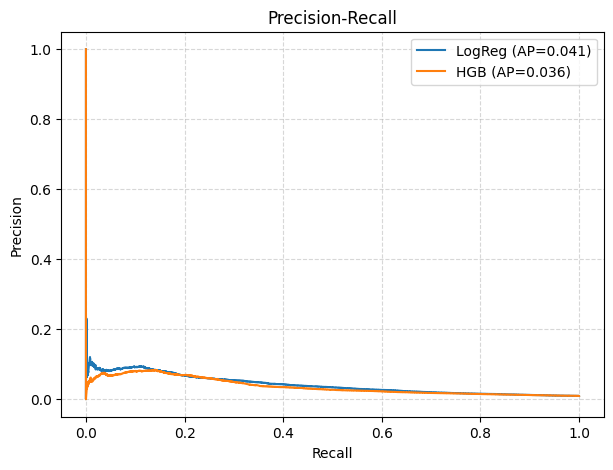

In [28]:

def plot_pr(y_true, scores_dict):
    plt.figure(figsize=(7,5))
    for name, s in scores_dict.items():
        p, r, _ = precision_recall_curve(y_true, s)
        ap = auc(r, p)
        plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

plot_pr(y_valid, {"LogReg": p_lr, "HGB": p_hgb})


## Búsqueda de umbral (F2)

In [32]:
def report_at_threshold(y_true, y_prob, thr=0.5, name="model"):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n{name} @ threshold={thr:.2f}")
    print(classification_report(y_true, y_pred, digits=3))

report_at_threshold(y_valid, p_lr, thr=0.5, name="LogReg")
report_at_threshold(y_valid, p_hgb, thr=0.5, name="HGB")


LogReg @ threshold=0.50
              precision    recall  f1-score   support

           0      0.995     0.762     0.863    302526
           1      0.025     0.631     0.048      2907

    accuracy                          0.761    305433
   macro avg      0.510     0.696     0.455    305433
weighted avg      0.986     0.761     0.855    305433


HGB @ threshold=0.50
              precision    recall  f1-score   support

           0      0.993     0.911     0.950    302526
           1      0.038     0.368     0.069      2907

    accuracy                          0.905    305433
   macro avg      0.516     0.639     0.510    305433
weighted avg      0.984     0.905     0.942    305433



In [15]:

from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

def sweep_threshold(y_true, y_prob, beta=2.0):
    ths = np.linspace(0.0, 1.0, 101)
    rows = []
    for t in ths:
        y_pred = (y_prob >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0, beta=beta)
        rows.append((t, p, r, f))
    out = pd.DataFrame(rows, columns=["thr","precision","recall","Fbeta"])
    return out.sort_values("Fbeta", ascending=False).head(10)

print("Top F2 — LogReg:\n", sweep_threshold(y_valid, p_lr, beta=2.0))
print("Top F2 — HGB:\n", sweep_threshold(y_valid, p_hgb, beta=2.0))


Top F2 — LogReg:
      thr  precision    recall     Fbeta
70  0.70   0.052824  0.318197  0.158722
71  0.71   0.053933  0.302374  0.157380
72  0.72   0.055358  0.288958  0.156705
69  0.69   0.050652  0.327485  0.156461
68  0.68   0.049154  0.341589  0.155985
73  0.73   0.056792  0.275542  0.155643
67  0.67   0.047602  0.356381  0.155127
74  0.74   0.057789  0.262126  0.153542
75  0.75   0.059618  0.252150  0.153200
66  0.66   0.045628  0.367045  0.152372
Top F2 — HGB:
      thr  precision    recall     Fbeta
76  0.76   0.074377  0.299966  0.186708
75  0.75   0.072527  0.305126  0.185892
74  0.74   0.070948  0.311662  0.185671
77  0.77   0.075282  0.291366  0.185104
73  0.73   0.069015  0.316133  0.184213
72  0.72   0.067068  0.321637  0.182839
78  0.78   0.075700  0.280014  0.181851
71  0.71   0.065301  0.327829  0.181718
70  0.70   0.063608  0.334365  0.180609
69  0.69   0.061959  0.342277  0.179687


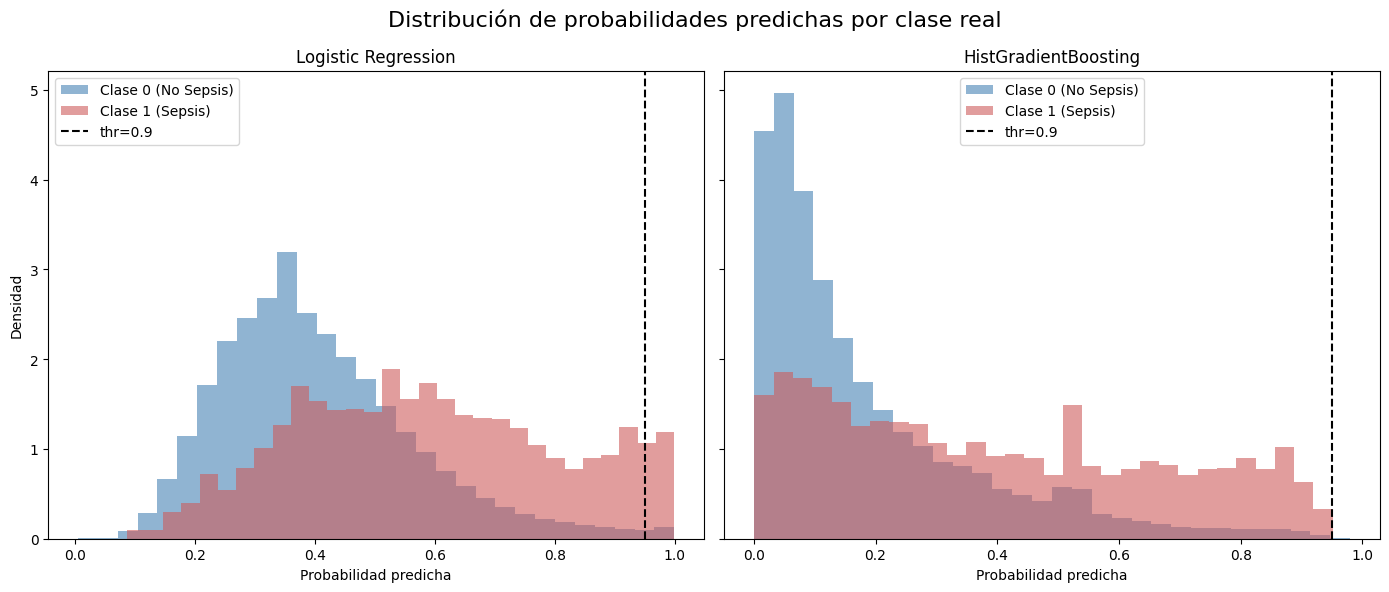

In [33]:
# Suponiendo que ya tienes:
# y_valid → etiquetas verdaderas
# pred_proba_lr  → probabilidades predichas por Logistic Regression
# pred_proba_hgb → probabilidades predichas por HistGradientBoosting

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# -------- LogReg --------
probas_pos_lr = p_lr[y_valid == 1]
probas_neg_lr = p_lr[y_valid == 0]

axes[0].hist(probas_neg_lr, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[0].hist(probas_pos_lr, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[0].axvline(0.95, color="black", linestyle="--", label="thr=0.9")
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Probabilidad predicha")
axes[0].set_ylabel("Densidad")
axes[0].legend()

# -------- HGB --------
probas_pos_hgb = p_hgb[y_valid == 1]
probas_neg_hgb = p_hgb[y_valid == 0]

axes[1].hist(probas_neg_hgb, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[1].hist(probas_pos_hgb, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[1].axvline(0.95, color="black", linestyle="--", label="thr=0.9")
axes[1].set_title("HistGradientBoosting")
axes[1].set_xlabel("Probabilidad predicha")
axes[1].legend()

plt.suptitle("Distribución de probabilidades predichas por clase real", fontsize=16)
plt.tight_layout()
plt.show()


## Guardar modelos

In [14]:

Path("models").mkdir(exist_ok=True)
dump(pipe_lr, "../models/logreg_h6.joblib")
dump(hgb, "../models/hgb_h6.joblib")
print("Guardados:", "models/logreg_h6.joblib", "y", "models/hgb_h6.joblib")


Guardados: models/logreg_h6.joblib y models/hgb_h6.joblib
